# 人脸识别简介

人脸识别的目标是对于给定的两张图片分别检测两张图片中的人脸并判断其是否为同一人脸，这里我们利用开源的pytorch repo对人脸识别的流程做个介绍

In [1]:
import sys
sys.path.append('./align')
from PIL import Image
import matplotlib.pyplot as plt
from align import detector
from align_trans import get_reference_facial_points, warp_and_crop_face
from backbone.model_irse import IR_50
%matplotlib inline
import numpy as np
import cv2
import torch
def plot_images(imgs):
    for i,img in enumerate(imgs):
        plt.subplot(2,2,i+1)
        plt.imshow(imgs[i])

## 数据准备

我们从网上下载开复老师和Hinton的正面照片各一张，展示如下：

In [2]:
img_kaifu_1 = Image.open('kaifu_1.jpg')
img_kaifu_2 = Image.open('kaifu_2.jpg')
img_hinton_1 = Image.open('hinton_1.jpeg')
img_hinton_2 = Image.open('hinton_2.jpg')

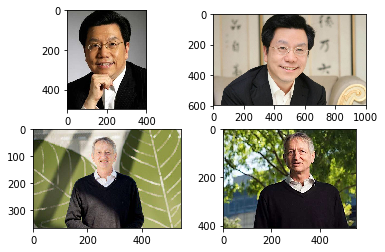

In [3]:
plot_images([img_kaifu_1,img_kaifu_2,img_hinton_1,img_hinton_2])

## 人脸检测

人脸检测这里使用MTCNN方法，其目标是对于给定的图片检测图片中的所有人脸。利用封装好的函数，我们将四张图的人脸展示如下：

./align/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile = True)
./align/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/qizhicai/research/face.evoLVe.PyTorch/align/detector.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
./align/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/qizhicai/research/face.evoLVe.PyTorch/align/detector.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
./align/get_nets.p

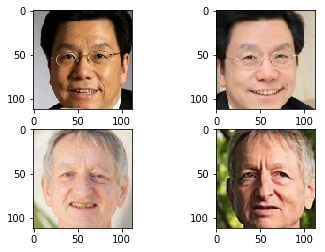

In [4]:
def align_face(img,size=(112,112)):
    reference = get_reference_facial_points(default_square = True) * size[0]/112.
    landmarks= detector.detect_faces(img)[1]
    facial5points = [[landmarks[0][j], landmarks[0][j + 5]] for j in range(5)]
    warped_face = warp_and_crop_face(np.array(img), facial5points, reference, size)
    return warped_face

img_kaifu_1_align = align_face(img_kaifu_1)
img_kaifu_2_align = align_face(img_kaifu_2)
img_hinton_1_align = align_face(img_hinton_1)
img_hinton_2_align = align_face(img_hinton_2)
plot_images([img_kaifu_1_align,img_kaifu_2_align,img_hinton_1_align,img_hinton_2_align])

## 人脸识别

在检测完毕后，原始图片已经处理为112*112的仅包含人脸的正方形图片，对预处理好的人脸图片，人脸识别模型将分别对每个人脸产生一个低维向量，而这些向量之间的距离表示了人脸的相似与否，这里我们使用如下代码将这四张图片分别映射至四个低维向量`feat_kaifu_1`，`feat_kaifu_2`， `feat_hinton_1`， `feat_hinton_2`中

In [5]:
def img2tensor(img):    
    img = img.swapaxes(1, 2).swapaxes(0, 1)
    img = np.reshape(img, [1, 3, 112, 112])
    img = np.array(img, dtype = np.float32)
    img = (img - 127.5) / 128.0
    img = torch.from_numpy(img)
    return img
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

model = IR_50([112,112])
model.load_state_dict(torch.load('backbone_ir50_ms1m_epoch120.pth',map_location='cpu'))
model.eval()
feat_kaifu_1 = l2_norm(model(img2tensor(img_kaifu_1_align)))
feat_kaifu_2 = l2_norm(model(img2tensor(img_kaifu_2_align)))
feat_hinton_1 = l2_norm(model(img2tensor(img_hinton_1_align)))
feat_hinton_2 = l2_norm(model(img2tensor(img_hinton_2_align)))

最后我们使用向量之间的点积衡量他们之间的相似度，具体结果如下

In [6]:
print('face kaifu_1 vs kaifu_2, similarity: {}'.format(feat_kaifu_1.detach().numpy().dot(feat_kaifu_2.detach().numpy().T)))
print('face hinton_1 vs hinton_2, similarity: {}'.format(feat_hinton_1.detach().numpy().dot(feat_hinton_2.detach().numpy().T)))
print('face hinton_1 vs kaifu_1, similarity: {}'.format(feat_hinton_1.detach().numpy().dot(feat_kaifu_1.detach().numpy().T)))
print('face hinton_1 vs kaifu_2, similarity: {}'.format(feat_hinton_1.detach().numpy().dot(feat_kaifu_2.detach().numpy().T)))
print('face hinton_2 vs kaifu_1, similarity: {}'.format(feat_hinton_2.detach().numpy().dot(feat_kaifu_1.detach().numpy().T)))
print('face hinton_2 vs kaifu_2, similarity: {}'.format(feat_hinton_2.detach().numpy().dot(feat_kaifu_2.detach().numpy().T)))


face kaifu_1 vs kaifu_2, similarity: [[0.84475905]]
face hinton_1 vs hinton_2, similarity: [[0.81772304]]
face hinton_1 vs kaifu_1, similarity: [[0.04726546]]
face hinton_1 vs kaifu_2, similarity: [[0.03553546]]
face hinton_2 vs kaifu_1, similarity: [[0.05217183]]
face hinton_2 vs kaifu_2, similarity: [[0.07226112]]


可以看出，我们的预训练模型是能够正确将开复老师和hinton的人脸区分开来的。